In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip drive/MyDrive/trainingsdata.zip

Archive:  drive/MyDrive/trainingsdata.zip
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: X_test.csv              
  inflating: X_train.csv             
  inflating: X_val.csv               
  inflating: y_test.npy              


In [ ]:
!unzip trainingsdata.zip

Archive:  trainingsdata.zip
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: X_test.csv              
  inflating: X_train.csv             
  inflating: X_val.csv               
  inflating: y_test.npy              


In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: lda_train.npy           
  inflating: lda_val.npy             
  inflating: X_test_ft_avg.npy       
  inflating: X_test_ft_usif.npy      
  inflating: X_test_glove_avg.npy    
  inflating: X_test_glove_usif.npy   
  inflating: X_train_ft_avg.npy      
  inflating: X_train_ft_usif.npy     
  inflating: X_train_glove_avg.npy   
  inflating: X_train_glove_usif.npy  
  inflating: X_val_ft_avg.npy        
  inflating: X_val_ft_usif.npy       
  inflating: X_val_glove_avg.npy     
  inflating: X_val_glove_usif.npy    
  inflating: lda_test.npy            


# Imports
Here the imports are listed, which are important for the model

In [2]:
!pip install gensim
!pip install -U git+https://github.com/oborchers/Fast_Sentence_Embeddings

  Cloning https://github.com/oborchers/Fast_Sentence_Embeddings to /tmp/pip-req-build-07budv97
  Running command git clone -q https://github.com/oborchers/Fast_Sentence_Embeddings /tmp/pip-req-build-07budv97


In [3]:
import numpy
import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import tensorflow_hub as hub

#logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

#type annotation
from typing import *
tf.get_logger().setLevel('ERROR')

import gc
gc.enable()

SEED = 100    #reproduceability
from tensorflow.keras.layers import Embedding

## Vectorisation (if needed)
If already vectorised documents are used, this step can be ignored

### Bow vectoriser and Sentence encoder

In [4]:
def getVectoriser(kind:str = "tfIdf", vocab=512, ngram_range=(1,1), trainingsData=None):
  """This function creates the vectoriser according to the parameter and returns it.
      It can be either a count, tfIdf or sentence vectoriser.

    Args:
        kind (str): The kind of the vectoriser such as 'tfIdf', 'sentence' or 'count'
        vocab (number): The length of the vocabulary
        ngram_range (any): The ngram range
        trainingsData (any): The trainingsdata

    Returns:
        The vectoriser object
    """
  global vectoriser_func
  if kind is "tfIdf":
    vectoriser = TfidfVectorizer(lowercase=True, min_df=2, max_features=vocab, ngram_range=ngram_range, stop_words="english")
    trainVectoriser(vectoriser, trainingsData)
    return vectoriser
  elif kind is "count":
    vectoriser = CountVectorizer(lowercase=True, min_df=2, max_features=vocab, ngram_range=ngram_range, stop_words="english")
    trainVectoriser(vectoriser, trainingsData)
    return vectoriser
  elif kind is "sentence":
    return hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")


def trainVectoriser(vectoriser, trainingsData):
  """This function is used to train the vectoriser

    Args:
        trainingsData (any): The data used for training
        vectoriser (any): The vectoriser itself

    Returns:
        The vectorised data.
    """
  
  text_ds = trainingsData.flatten()
  tmp = vectoriser.fit_transform(text_ds)
  logger.info(tmp.shape)
  del text_ds, tmp
  gc.collect()

def batchVectorisation(dfData, vectoriser, kindOfvectoriser:str):
  """This function loads the data in batches to reduce RAM requirenments.
    Also it dstinguishes between 'sentence' for the sentence encoder and plain sklearn
    vectorisers

    Args:
        dfData (any): The data of the dataframe
        vectoriser (any): The vectoriser itself
        kindOfvectoriser (str): This is the 'name' of the vectoriser, such as tfidf

    Returns:
        The vectorised data.
    """
  
  if kindOfvectoriser is "sentence":
    vecFunc = lambda string: vectoriser(tf.constant(string)) 
  else:
    vecFunc = lambda string: vectoriser.transform(string).toarray()
  l = dfData[:,0]
  r = dfData[:,1]
  returnValue = [[],[]]
  batch_size = 250
  while len(l) >0 :
    le = vecFunc(l[:batch_size]) #vectoriser.transform(l[:batch_size]).toarray()
    re = vecFunc(r[:batch_size]) #vectoriser.transform(r[:batch_size]).toarray()

    if len(returnValue[0]) == 0:
      returnValue[0] = le
      returnValue[1] = re
    else:
      returnValue[0] = numpy.concatenate((returnValue[0], le), axis=0)
      returnValue[1] = numpy.concatenate((returnValue[1], re), axis=0)

    l = l[batch_size:]
    r = r[batch_size:]
    logger.info(f"{returnValue[0].shape} todo {l.shape}")
  return returnValue

def vectoriseData(vectoriser, training, validation, kind:str = "tfidf"):
  """This function vectorises the data provided given the vectoriser provided.

    Args:
        vectoriser (any): This is the vectoriser object, it can be either be the
        universal setnence encoder or one of the bow vectorisers
        training (any): Is the trainingsdata data
        validation (any): Is the validation data
        kind (str): Is the data proviced

    Returns:
        The list of tokenised documents
    """
  X_train_list = batchVectorisation(training, vectoriser, kind)
  X_val_list = batchVectorisation(validation, vectoriser, kind)
  return X_train_list, X_val_list

### GloVe; Fasttext usif and avg document embeddings

In [5]:
from gensim.models import Word2Vec, FastText
!pip install -U fse
from fse.models.average import FAST_VERSION
print(FAST_VERSION) #1 means available
from fse.models import Average, uSIF
import gensim.downloader as api
from fse import IndexedList

class EmbeddingModels():
  """This class is used to create a Embedding model, which is able to vectorise documents.
    Returns:
        The document embeddings producing object
    """
  def __init__(self, vocab_len, trainingsdata, embedName, combiName):
    self.tokenizer = TfidfVectorizer(lowercase=True, min_df=2, max_features=vocab_len, ngram_range=(1,1), stop_words="english").build_tokenizer()
    tokdata = self.tokenize(trainingsdata)

    self.embed = self.get_embedding(tokdata, embedName, vocab_len)
    logger.error("got embedding")

    tokdata = IndexedList(tokdata)
    logger.error("csp")

    self.model = self.getMergingMethod(combiName, self.embed, embedName, vocab_len)
    logger.error("got combi")
    self.model.train(tokdata)
    logger.error("finished training")
  
  def getMergingMethod(self, combiName:str, embedding, embedName:str, voc_len):
    """This function returns the merging method for the word embeddings.

    Args:
        embedding (any): Serves the word embeddings
        embedName (str): is the name of the embeddings
        voc_len (number): is the lenght of the vocabulary
        combiName (str): embedName is the name of the embeddings

    Returns:
        The Merging method
    """
    if combiName is "avg":
      return Average(embedding)
    else:
      if embedName is "glove":
        return uSIF(embedding, workers=2, lang_freq="en")
      else:
        return uSIF(embedding, length=voc_len)

  def get_embedding(self, trainingsdata, embedName:str, vocab_len):
    """This function creates and returns an embedding for the given trainingsdata.

    Args:
        trainingsdata (List[str]): Is the data proviced
        embedding (any): Serves the word embeddings
        embedName (str): is the name of the embeddings
        vocab_len (number): is the lenght of the vocabulary
        combiName (str): embedName is the name of the embeddings

    Returns:
        The word level embedding function 
    """
    if embedName is "glove":
      return api.load("glove-wiki-gigaword-100")
    elif embedName is "fasttext":
      return FastText(window=3, min_count=1, sentences=trainingsdata, size=vocab_len)
    else:
      return Word2Vec(trainingsdata, min_count=1, size=vocab_len)

  def tokenize(self, data)->list:
    """This function tokenises all the documents in the data.

    Args:
        data (any): Is the data proviced

    Returns:
        The list of tokenised documents
    """
    return [self.tokenizer(doc) for doc in data]

  def predict(self, data)->list:
    """This function creates the document embeddings

    Args:
        data (any): Is the data proviced

    Returns:
        The document embeddings
    """
    tokenized_data = self.tokenize(data)
    idxTok = IndexedList(tokenized_data)
    inf_tokens = list(map(lambda tokenList: (tokenList, 0), tokenized_data))
    #print(numpy.array(inf_tokens))
    return list(map(lambda inf_data: self.model.infer([inf_data])[0], inf_tokens))

1


## LDA

In [6]:
class NumberNormalizingVectorizer(TfidfVectorizer):
  """This class creates a custom vectoriser used for the LDA.

    Returns:
        A object of the Vectoriser
    """
  def build_tokenizer(self):
    tokenize = super().build_tokenizer()
    return lambda doc: list(self.number_normalizer(tokenize(doc)))

  def number_normalizer(self, tokens):
    return ("NUMBER" if token[0].isdigit() else token for token in tokens)

class GenerateLdaTopics():
  """
  This Class is used to generate the LDA
  """
  def __init__(self, _n_topics=200):
    self.n_topics = _n_topics
    self.cv = NumberNormalizingVectorizer(lowercase=True, min_df=5, max_features=20000, max_df=0.5, stop_words="english",token_pattern='[a-zA-Z]+')
    self.lda = LatentDirichletAllocation(n_components=_n_topics, random_state=0,n_jobs=-1)
    self.vocab = None
    
  def fit(self, data):
    """This function is used to fit the LDA model.

    Args:
        data (any): The data passed to the vectoriser
    """
    vectorised_data = self.cv.fit_transform(X_train.flatten())
    logger.info("data vectorised")
    self.vocab = self.cv.get_feature_names()
    logger.info("fitting lda")
    self.lda.fit(vectorised_data)

  def predict(self, data):
    """This function returns the topic propabilities for the documents.

    Args:
        data (any): The data to produce the document-topic matri from

    Returns:
        The document-topic matrix
    """
    vec_data = self.cv.transform(data)     #document-term matrix
    return self.lda.transform(vec_data)    #document-topic matrix

  def print_topics(self,n_top_words=5):
    """In order to visualise the topics,
    this document prints representatives of the topics to show which words are contained within each topic.

    Args:
        n_top_words (number): The number words displayed for the topics

    Returns:
        A trainable model
    """
    for topic, comp in enumerate(self.lda.components_):  #iterate through the topic-term matrix
      word_idx = numpy.argsort(comp)[:-n_top_words-1:-1]
      words = [self.vocab[i] for i in word_idx]
      print('Topic: %d' % topic)
      print('  %s' % ', '.join(words)) 

  def print_predictedTopics(self, data, n_top_topics = 5):
    """This function appends the vector length onto the vector itself.

    Args:
        data (number): The length of the documents
        n_top_topics (number): The number of topics

    Returns:
        A trainable model
    """
    pred = self.predict(data)
    topicsAndPropabilities = []
    for p in pred:    #for document in document-topic
      top_topics = p.argsort()[:-n_top_topics - 1:-1]
      propabilities = p[top_topics]
      topicsAndPropabilities.append([top_topics, propabilities])#print k best topics
    return topicsAndPropabilities

#The classifier
To change the classifier, the concatenation layer in the *createModel* function has to be edited.


In [7]:
class LayerAppendSum(tf.keras.layers.Layer):
  """This function appends the vector length onto the vector itself.
    """
  def __init__(self):
      super(LayerAppendSum, self).__init__()

  def call(self, inputs):
    """This function gets automatically called with the data.

    Args:
        inputs (any): A vector within a vector of all the batches

    Returns:
        A concatenated vector length onto the vector 
    """
    def mapfunc(vec):
      reduced_sum = tf.reduce_sum(vec)
      reshaped = tf.reshape(reduced_sum, [-1])
      return tf.concat([vec, reshaped], 0)
    return tf.map_fn(lambda batch: mapfunc(batch), inputs)  #tf.concat([inputs, reduced])


def createModel(vec_len:int):
  """This function creates a classifier for feature lists of the vec_len provided

    Args:
        vec_len (int): The length of the documents

    Returns:
        A trainable model
    """
  ain = keras.Input(shape=(vec_len,), dtype="float")
  bin = keras.Input(shape=(vec_len,), dtype="float")

  a = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=0))(ain)
  b = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=0))(bin)

  avg_layer = tf.keras.layers.Average(name="avg")([a, b])
  mult_layer = tf.keras.layers.Multiply(name="mult")([a,b])
  sub_layer = tf.keras.layers.Subtract(name="sub")([a, b])

  cosine_sim = tf.keras.layers.Dot(axes=1, normalize=True, name="cosine_similarity")([a,b])
  #topic_sim = tf.keras.layers.Dot(axes=1, normalize=True, name="topic_similarity")([x,y])

  #avg_layer = LayerAppendSum()(avg_layer)
  #mult_layer = LayerAppendSum()(mult_layer)
  #sub_layer = LayerAppendSum()(sub_layer)

  hidden = tf.keras.layers.concatenate([sub_layer, avg_layer, mult_layer,cosine_sim])#a,b , topic_sim])

  outputs = layers.Dense(5, activation='softmax')(hidden)

  model = keras.Model([ain,bin], outputs)   #,x,y
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
  #model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy']),
  return model

def download_model(model):
  """
  This function is used to download models from google collab specifficly.
  !tar -czvf model.tar.gz model/ is used for tarring the model
  !tar -xvzf model.tar.gz is used for ent-tarring the model
  """
  model.save(f"./tmp_model")
  !tar -czvf tmp_model.tar.gz tmp_model/
  from google.colab import files
  files.download('tmp_model.tar.gz')

def eval_model(predLabel:List[int], true_label:List[int]):
  """This function is used to determine the precision, recall and f1 score of a given model.

    Args:
        predLabel (List[int]): The predicted label of the model
        predLabel (List[int]): The gold standard label

    Returns:
        The precission, recall, f1, and f1_macro scores
    """
  f1_scores = sklearn.metrics.f1_score(y_true=true_label, y_pred=predLabel, average=None)
  precission = sklearn.metrics.precision_score(y_true=true_label, y_pred=predLabel, average=None)
  recall = sklearn.metrics.recall_score(y_true=true_label, y_pred=predLabel, average=None)

  precission = list(map(lambda x: round(x, 4), precission))
  recall = list(map(lambda x: round(x, 4), recall))
  f1 = list(map(lambda x: round(x, 4), f1_scores))
  f1_macro =  round(sum(f1)/len(f1), 4)
  return precission, recall, f1, f1_macro

## Running the model configuration

In [8]:
#newLda = GenerateLdaTopics()
#newLda.fit(X_train.flatten())

#### Finding the best vectoriser configuration

In [9]:
def loadTrainAndValFeatures(nameTrainDataset: str, nameValDataset: str) -> list:
  """This function loads the training and validation data.

    Args:
        nameTrainDataset (str): The name of the training dataset
        nameValDataset (str): The name of the validation dataset

    Returns:
        Both, the training and validation dataset
    """
  X_train:numpy.ndarray = loadCSVData("X_train")
  X_val:numpy.ndarray = loadCSVData("X_val")

  return X_train, X_val

def loadCSVData(name:str) -> numpy.ndarray:
  """This function loads SCV give the name.

    Args:
        name (str): The name of the dataset

    Returns:
        The numpy array
    """
  return pd.read_csv(f"{name}.csv")[["IssueA", "IssueB"]].values.astype("str")

def loadNpData(name:str)-> numpy.ndarray:
  """This function loads numpy data give the name.

    Args:
        name (str): The name of the dataset

    Returns:
        The numpy array
    """
  return numpy.load(name+".npy", allow_pickle=True)

def loadTrainAndValResults(nameTrainDataset: str, nameValDataset: str):
  """This function loads the training and validation results.

    Args:
        nameTrainDataset (str): The name of the training dataset
        nameValDataset (str): The name of the validation dataset

    Returns:
        Both, the training and validation results
    """
  Y_train = loadNpData("y_train")
  Y_val = loadNpData("y_val")
  Y_val = numpy.array([numpy.array(x) for x in Y_val])
  Y_train = numpy.array([numpy.array(x) for x in Y_train])
  return Y_train, Y_val


def getVectorisedDataFromDataset(lda:bool, name:str, lda_name:str = None):
  """This function loads a specific X_train and X_val dataset and appends lda if needed.

    Args:
        lda (bool): Whether or not the model uses lds.
        name (str): The The name of the data to load.
        lda_name (str): The name of the lda datato load.

    Returns:
        The loaded data
    """
  tmp_list = list(loadNpData(name))

  if lda:
    lda_data = list(loadNpData(lda_name))
    tmp_list.append(lda_data[0])
    tmp_list.append(lda_data[1])

  return tmp_list

def createVectorisedData(name:str,ngram,voc:int, lda:bool, X_train, X_val):
  """This function creates vectorised data, by creating a vectoriser given the requirenments specified and transforms the data given.

    Args:
        lda (bool): Whether or not the model uses lds.
        name (str): The name of the data to load.
        voc (int): The length of the vocabulary.
        ngram (tuple): The ngram itself.
        X_train (any): The training data.
        X_val (any): The validation data.

    Returns:
        The training and validation data
    """
  newLda= None
  vectoriser = getVectoriser(trainingsData=X_train, vocab=voc, kind=name, ngram_range=ngram)
  X_train_list, X_val_list = vectoriseData(vectoriser, X_train, X_val, kind=name)
  if lda:
    newLda = GenerateLdaTopics()
    newLda.fit(X_train.flatten())
    tl = newLda.predict(X_train[:,0])
    tr = newLda.predict(X_train[:,1])
    vl = newLda.predict(X_val[:,0])
    vr = newLda.predict(X_val[:,1])

    X_train_list.append(tl)
    X_train_list.append(tr)
    X_val_list.append(vl)
    X_val_list.append(vr)

  return X_train_list, X_val_list
  
def createAndEvaluateModel(X_train_list:list, X_val_list:list, Y_train, Y_val, voc:int):
  """This function creates and evaluates a model.
    Args:
        X_train_list (list): The training data.
        X_val_list (list): The validation data.
        Y_train (numpy.ndarray): The training solution.
        Y_val (numpy.ndarray): The validation solution.
        voc (int): The vocabulary size.

    Returns:
        The f1 scores evaluated
    """
  model = createModel(voc)
  model.fit(x=X_train_list, y=Y_train, batch_size = 25, epochs=25, validation_data=(X_val_list, Y_val))
  output = model.predict(X_val_list, batch_size=15)
  output = list(map(numpy.argmax, output))
  y_val_int = list(map(numpy.argmax, Y_val))

  return eval_model(output, y_val_int)


def trainAndEvaluateModel(vectorisedData:bool, config, lda:bool):
  """
  This function creates and evaluates multiple models.

    Args:
        vectorisedData (bool): The training data.
        config (str): The validation data.
        lda (bool): Whether or not LDA was used.

    Returns:
        The best vectoriser vonfiguration for the model
    """
  precissions = []
  recalls = []
  f1s = []
  f1_macros = []
  Y_train, Y_val = loadTrainAndValResults("nameTrainDataset", "nameValDataset")
  
  if vectorisedData:
    for name in config:
      X_train_list = getVectorisedDataFromDataset(lda, f"X_train_{name}")
      X_val_list = getVectorisedDataFromDataset(lda, f"X_val_{name}")
      voc = len(X_train_list[0][0])

      precission, recall, f1, f1_macro = createAndEvaluateModel(X_train_list, X_val_list, Y_train, Y_val, voc)
      precissions.append(precission)
      recalls.append(recall)
      f1s.append(f1)
      f1_macros.append(f1_macro)
      gc.collect()

  else:
    for name,ngram,voc in config:
      X_train, X_val = loadTrainAndValFeatures("nameTrainDataset", "nameValDataset")
      X_train_list, X_val_list = createVectorisedData(name,ngram,voc, lda, X_train, X_val)

      precission, recall, f1, f1_macro = createAndEvaluateModel(X_train_list, X_val_list, Y_train, Y_val, voc)
      precissions.append(precission)
      recalls.append(recall)
      f1s.append(f1)
      f1_macros.append(f1_macro)
      gc.collect()
  
  npf1_macros = list(map(lambda x: round(x, 4), f1_macros))

  bestIndex = npf1_macros.index(max(npf1_macros))
  bestVecConfig = vectoriser_config[bestIndex]
  #print(f"\nBest model config:\n{bestVecConfig[0]}:{bestVecConfig[1]}:{bestVecConfig[2]} = {max(npf1_macros)}")
  print(f"\nBest model config:\n{bestVecConfig} = {max(npf1_macros)}")
  return bestVecConfig

#### Running the best vectoriser configuration
The best vectoriser vonfiguration for the model is then run on the test dataset for evaluation purposes

In [14]:
def printLatexOutput(output:numpy.ndarray, Y_test_int:numpy.ndarray, name:str, ngram, voc:int):
  """
  This function creates a latex formated output to show the f1, precision, recall performances.

    Args:
        output (numpy.ndarray): The output of the classifier.
        Y_test_int (numpy.ndarray): The integer values of the gold labels
        name (str): The name of the vectorisation strategie.
        ngram (tuple): The ngram.
        voc (int): The vocabulary size.

    Returns:
        A latex formated output
    """
  output = list(map(numpy.argmax, output))
  precission, recall, f1, f1_macro = eval_model(output, Y_test_int)
  labels = numpy.array(['unrelated', 'duplicate', '<=>', '<=', '=>'])
  rearrange = numpy.array([4,3,2,0,1])
  labels = labels[rearrange]
  precission = numpy.array(precission)[rearrange]
  recall = numpy.array(recall)[rearrange]
  f1 = numpy.array(f1)[rearrange]

  ng = "" if ngram[1] == 1 else "_{,Un+Bigram}"
  output = f"{name}_{{{voc}}}{ng}" + "\t\t"
  for j in range(len(labels)):
    output += f"& {precission[j]} & {recall[j]} "
  print(output + "\\\\")
  output = f"{name}_{{{voc}}}{ng}" + "\t\t"

  print("\nf1 scores\t\t"+ "\t".join(labels) + "\tmacro f1")
  for j in range(len(labels)):
    output += f"& {f1[j]} "
  output += f" & {f1_macro}"
  print(output + "\\\\")

def vectoriseDataReturnVectoriser(name:str, ngram, voc:int, lda:bool):
  """
  This function loads the training data and returns it in additino to the vectoriser and a LDA if present.

    Args:
        name (str): The name of the vectorisation strategie.
        ngram (tuple): The ngram.
        voc (int): The vocabulary size.
        lda (bool): Whether or not a LDA model was used.

    Returns:
        The trainings and validation data in addition to an vectoriser, and LDA
    """

  X_train, X_val = loadTrainAndValFeatures("nameTrainDataset", "nameValDataset")
  Y_train, Y_val = loadTrainAndValResults("nameTrainDataset", "nameValDataset")

  vectoriser = getVectoriser(trainingsData=X_train, vocab=voc, kind=name, ngram_range=ngram)
  X_train_list, X_val_list = vectoriseData(vectoriser, X_train, X_val, kind=name)
  newLda = None
  if lda:
    newLda = GenerateLdaTopics()
    newLda.fit(X_train.flatten())
    tl = newLda.predict(X_train[:,0])
    tr = newLda.predict(X_train[:,1])
    vl = newLda.predict(X_val[:,0])
    vr = newLda.predict(X_val[:,1])

    X_train_list.append(tl)
    X_train_list.append(tr)
    X_val_list.append(vl)
    X_val_list.append(vr)
  return X_train_list, X_val_list, vectoriser, newLda

def loadAndVectoriseTestData(name:str, vectoriser, lda:bool, newLda):
  """
  This function cloads the test data and vectorises it using a given vectoriser.

    Args:
        name (str): The name of the vectorisation strategie.
        vectoriser (any): The vectoriser.
        newLda (any): The LDA model or None.
        lda (bool): Whether or not a LDA model was used.

    Returns:
        The vectorised data
    """
  x_test:numpy.ndarray = loadCSVData("X_test") 
  y_test:numpy.ndarray = loadNpData("y_test")

  X_test: List[numpy.ndarray] = batchVectorisation(x_test, vectoriser, name)#[test_dev[:,0],test_dev[:,1]]### list of numpy.ndarray[str]#
  if lda:
    tsl = newLda.predict(x_test[:,0])
    tsr = newLda.predict(x_test[:,1])
    X_test.append(tsl)
    X_test.append(tsr)

  Y_test_int:numpy.ndarray = numpy.array([numpy.argmax(numpy.array(tmp)) for tmp in y_test])
  return X_test, Y_test_int

def createBestModel(name:str,ngram,voc:int, lda:bool):
  """
  This function creates the 'best' model, using the data provided.

    Args:
        name (str): The name of the vectorisation strategie.
        ngram (tuple): The ngram.
        voc (int): The vocabulary size.
        lda (bool): Whether or not a LDA model was used.

    Returns:
        The 'best' model itself
  """
  X_train_list, X_val_list, vectoriser, newLda = vectoriseDataReturnVectoriser(name, ngram, voc, lda)
  Y_train, Y_val = loadTrainAndValResults("nameTrainDataset", "nameValDataset")
  model = createModel(voc)
  model.fit(x=X_train_list, y=Y_train, batch_size = 25, epochs=25, validation_data=(X_val_list, Y_val))

  #del X_train, X_val, Y_train, Y_val
  gc.collect()

  X_test, Y_test_int = loadAndVectoriseTestData(name, vectoriser, lda, newLda)

  output = model.predict(X_test, batch_size=15)
  #print(numpy.array([f"{rnd(x)} {numpy.argmax(x)}" for x in output]))
  printLatexOutput(output, Y_test_int, name, ngram, voc)
  return model
 

def rnd(num:float)->float:
  """
  This function rounds the number given.

    Args:
        num (float): The number itself.

    Returns:
        The rounded number
    """
  return list(map(lambda x: round(x, 4), num))

vectoriser_config = [("count", (1,1), 512), ("tfIdf", (1,1), 512), ("count", (1,2), 512), ("tfIdf", (1,2), 512), 
                     ("count", (1,1), 1024), ("tfIdf", (1,1), 1024), ("count", (1,2), 1024), ("tfIdf", (1,2), 1024),
                     ("count", (1,1), 8192), ("tfIdf", (1,1), 8192), ("count", (1,2), 8192), ("tfIdf", (1,2), 8192),
                     ("count", (1,1), 16384), ("tfIdf", (1,1), 16384), ("count", (1,2), 16384), ("tfIdf", (1,2), 16384),
                     ("sentence",(1,1), 512)
                     ]

data_config = ["ft_avg", "glove_avg", "ft_usif", "glove_usif"]

name,ngram,voc = trainAndEvaluateModel(False, vectoriser_config, False)
model = createBestModel(name,ngram,voc, False)
#trainAndEvaluateModel(True, data_config, False)

INFO:root:(2380, 512)
INFO:root:(250, 512) todo (940,)
INFO:root:(500, 512) todo (690,)
INFO:root:(750, 512) todo (440,)
INFO:root:(1000, 512) todo (190,)
INFO:root:(1190, 512) todo (0,)
INFO:root:(250, 512) todo (420,)
INFO:root:(500, 512) todo (170,)
INFO:root:(670, 512) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 8ms/step - loss: 1.4934 - accuracy: 0.3370 - val_loss: 1.5212 - val_accuracy: 0.3164
Epoch 2/25
48/48 [==============================] - 0s 3ms/step - loss: 1.3729 - accuracy: 0.4429 - val_loss: 1.5111 - val_accuracy: 0.3000
Epoch 3/25
48/48 [==============================] - 0s 3ms/step - loss: 1.2984 - accuracy: 0.5059 - val_loss: 1.5030 - val_accuracy: 0.3149
Epoch 4/25
48/48 [==============================] - 0s 3ms/step - loss: 1.2501 - accuracy: 0.5529 - val_loss: 1.5063 - val_accuracy: 0.3149
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 1.2038 - accuracy: 0.5689 - val_loss: 1.5068 - val_accuracy: 0.3224
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1768 - accuracy: 0.5832 - val_loss: 1.5021 - val_accuracy: 0.3075
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1350 - accuracy: 0.6244 - val_loss: 1.5110 - val_accuracy: 0.3134
Epoch 8/25
48/48 [==

INFO:root:(2380, 512)
INFO:root:(250, 512) todo (940,)
INFO:root:(500, 512) todo (690,)
INFO:root:(750, 512) todo (440,)
INFO:root:(1000, 512) todo (190,)
INFO:root:(1190, 512) todo (0,)
INFO:root:(250, 512) todo (420,)
INFO:root:(500, 512) todo (170,)
INFO:root:(670, 512) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 8ms/step - loss: 1.5242 - accuracy: 0.3555 - val_loss: 1.5331 - val_accuracy: 0.3090
Epoch 2/25
48/48 [==============================] - 0s 3ms/step - loss: 1.3422 - accuracy: 0.5202 - val_loss: 1.5042 - val_accuracy: 0.3254
Epoch 3/25
48/48 [==============================] - 0s 3ms/step - loss: 1.2366 - accuracy: 0.5697 - val_loss: 1.4844 - val_accuracy: 0.3313
Epoch 4/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1489 - accuracy: 0.6126 - val_loss: 1.4746 - val_accuracy: 0.3493
Epoch 5/25
48/48 [==============================] - 0s 3ms/step - loss: 1.0873 - accuracy: 0.6387 - val_loss: 1.4663 - val_accuracy: 0.3448
Epoch 6/25
48/48 [==============================] - 0s 3ms/step - loss: 1.0305 - accuracy: 0.6824 - val_loss: 1.4648 - val_accuracy: 0.3522
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9838 - accuracy: 0.6899 - val_loss: 1.4660 - val_accuracy: 0.3507
Epoch 8/25
48/48 [==

INFO:root:(2380, 512)
INFO:root:(250, 512) todo (940,)
INFO:root:(500, 512) todo (690,)
INFO:root:(750, 512) todo (440,)
INFO:root:(1000, 512) todo (190,)
INFO:root:(1190, 512) todo (0,)
INFO:root:(250, 512) todo (420,)
INFO:root:(500, 512) todo (170,)
INFO:root:(670, 512) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 8ms/step - loss: 1.4965 - accuracy: 0.3361 - val_loss: 1.5384 - val_accuracy: 0.3313
Epoch 2/25
48/48 [==============================] - 0s 3ms/step - loss: 1.3753 - accuracy: 0.4546 - val_loss: 1.5300 - val_accuracy: 0.3269
Epoch 3/25
48/48 [==============================] - 0s 4ms/step - loss: 1.3004 - accuracy: 0.5067 - val_loss: 1.5295 - val_accuracy: 0.3224
Epoch 4/25
48/48 [==============================] - 0s 4ms/step - loss: 1.2599 - accuracy: 0.5353 - val_loss: 1.5274 - val_accuracy: 0.3000
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 1.2097 - accuracy: 0.5571 - val_loss: 1.5241 - val_accuracy: 0.3119
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1829 - accuracy: 0.5832 - val_loss: 1.5203 - val_accuracy: 0.3269
Epoch 7/25
48/48 [==============================] - 0s 3ms/step - loss: 1.1364 - accuracy: 0.6084 - val_loss: 1.5249 - val_accuracy: 0.3045
Epoch 8/25
48/48 [==

INFO:root:(2380, 512)
INFO:root:(250, 512) todo (940,)
INFO:root:(500, 512) todo (690,)
INFO:root:(750, 512) todo (440,)
INFO:root:(1000, 512) todo (190,)
INFO:root:(1190, 512) todo (0,)
INFO:root:(250, 512) todo (420,)
INFO:root:(500, 512) todo (170,)
INFO:root:(670, 512) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 7ms/step - loss: 1.5254 - accuracy: 0.3244 - val_loss: 1.5608 - val_accuracy: 0.2881
Epoch 2/25
48/48 [==============================] - 0s 4ms/step - loss: 1.3489 - accuracy: 0.4866 - val_loss: 1.5325 - val_accuracy: 0.2925
Epoch 3/25
48/48 [==============================] - 0s 3ms/step - loss: 1.2384 - accuracy: 0.5681 - val_loss: 1.5182 - val_accuracy: 0.3179
Epoch 4/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1608 - accuracy: 0.6025 - val_loss: 1.5092 - val_accuracy: 0.3090
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0893 - accuracy: 0.6521 - val_loss: 1.5030 - val_accuracy: 0.3239
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0374 - accuracy: 0.6664 - val_loss: 1.5002 - val_accuracy: 0.3239
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9886 - accuracy: 0.6908 - val_loss: 1.4961 - val_accuracy: 0.3358
Epoch 8/25
48/48 [==

INFO:root:(2380, 1024)
INFO:root:(250, 1024) todo (940,)
INFO:root:(500, 1024) todo (690,)
INFO:root:(750, 1024) todo (440,)
INFO:root:(1000, 1024) todo (190,)
INFO:root:(1190, 1024) todo (0,)
INFO:root:(250, 1024) todo (420,)
INFO:root:(500, 1024) todo (170,)
INFO:root:(670, 1024) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 9ms/step - loss: 1.4596 - accuracy: 0.3613 - val_loss: 1.5170 - val_accuracy: 0.3239
Epoch 2/25
48/48 [==============================] - 0s 6ms/step - loss: 1.2872 - accuracy: 0.5202 - val_loss: 1.5116 - val_accuracy: 0.3478
Epoch 3/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1886 - accuracy: 0.5756 - val_loss: 1.5211 - val_accuracy: 0.3119
Epoch 4/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1188 - accuracy: 0.6286 - val_loss: 1.5062 - val_accuracy: 0.3373
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0618 - accuracy: 0.6597 - val_loss: 1.5010 - val_accuracy: 0.3284
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0004 - accuracy: 0.6849 - val_loss: 1.5038 - val_accuracy: 0.3299
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9711 - accuracy: 0.6933 - val_loss: 1.5032 - val_accuracy: 0.3403
Epoch 8/25
48/48 [==

INFO:root:(2380, 1024)
INFO:root:(250, 1024) todo (940,)
INFO:root:(500, 1024) todo (690,)
INFO:root:(750, 1024) todo (440,)
INFO:root:(1000, 1024) todo (190,)
INFO:root:(1190, 1024) todo (0,)
INFO:root:(250, 1024) todo (420,)
INFO:root:(500, 1024) todo (170,)
INFO:root:(670, 1024) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 8ms/step - loss: 1.4843 - accuracy: 0.3689 - val_loss: 1.5042 - val_accuracy: 0.3254
Epoch 2/25
48/48 [==============================] - 0s 4ms/step - loss: 1.2154 - accuracy: 0.5790 - val_loss: 1.4808 - val_accuracy: 0.3493
Epoch 3/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0803 - accuracy: 0.6454 - val_loss: 1.4668 - val_accuracy: 0.3582
Epoch 4/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9827 - accuracy: 0.7050 - val_loss: 1.4741 - val_accuracy: 0.3687
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9012 - accuracy: 0.7294 - val_loss: 1.4574 - val_accuracy: 0.3716
Epoch 6/25
48/48 [==============================] - 0s 5ms/step - loss: 0.8418 - accuracy: 0.7681 - val_loss: 1.4593 - val_accuracy: 0.3672
Epoch 7/25
48/48 [==============================] - 0s 5ms/step - loss: 0.7765 - accuracy: 0.7975 - val_loss: 1.4557 - val_accuracy: 0.3597
Epoch 8/25
48/48 [==

INFO:root:(2380, 1024)
INFO:root:(250, 1024) todo (940,)
INFO:root:(500, 1024) todo (690,)
INFO:root:(750, 1024) todo (440,)
INFO:root:(1000, 1024) todo (190,)
INFO:root:(1190, 1024) todo (0,)
INFO:root:(250, 1024) todo (420,)
INFO:root:(500, 1024) todo (170,)
INFO:root:(670, 1024) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 8ms/step - loss: 1.4648 - accuracy: 0.3874 - val_loss: 1.5272 - val_accuracy: 0.2910
Epoch 2/25
48/48 [==============================] - 0s 5ms/step - loss: 1.2921 - accuracy: 0.5218 - val_loss: 1.5189 - val_accuracy: 0.3015
Epoch 3/25
48/48 [==============================] - 0s 5ms/step - loss: 1.1957 - accuracy: 0.5697 - val_loss: 1.5187 - val_accuracy: 0.2940
Epoch 4/25
48/48 [==============================] - 0s 5ms/step - loss: 1.1229 - accuracy: 0.6235 - val_loss: 1.5236 - val_accuracy: 0.3090
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0735 - accuracy: 0.6286 - val_loss: 1.5126 - val_accuracy: 0.3194
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0230 - accuracy: 0.6681 - val_loss: 1.5132 - val_accuracy: 0.3269
Epoch 7/25
48/48 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.6765 - val_loss: 1.5107 - val_accuracy: 0.3134
Epoch 8/25
48/48 [==

INFO:root:(2380, 1024)
INFO:root:(250, 1024) todo (940,)
INFO:root:(500, 1024) todo (690,)
INFO:root:(750, 1024) todo (440,)
INFO:root:(1000, 1024) todo (190,)
INFO:root:(1190, 1024) todo (0,)
INFO:root:(250, 1024) todo (420,)
INFO:root:(500, 1024) todo (170,)
INFO:root:(670, 1024) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 8ms/step - loss: 1.4929 - accuracy: 0.3588 - val_loss: 1.5066 - val_accuracy: 0.3149
Epoch 2/25
48/48 [==============================] - 0s 4ms/step - loss: 1.2291 - accuracy: 0.5664 - val_loss: 1.4840 - val_accuracy: 0.3299
Epoch 3/25
48/48 [==============================] - 0s 5ms/step - loss: 1.0946 - accuracy: 0.6403 - val_loss: 1.4726 - val_accuracy: 0.3343
Epoch 4/25
48/48 [==============================] - 0s 5ms/step - loss: 0.9902 - accuracy: 0.6891 - val_loss: 1.4688 - val_accuracy: 0.3388
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9152 - accuracy: 0.7202 - val_loss: 1.4688 - val_accuracy: 0.3403
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 0.8599 - accuracy: 0.7454 - val_loss: 1.4615 - val_accuracy: 0.3582
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.7995 - accuracy: 0.7824 - val_loss: 1.4601 - val_accuracy: 0.3627
Epoch 8/25
48/48 [==

INFO:root:(2380, 8192)
INFO:root:(250, 8192) todo (940,)
INFO:root:(500, 8192) todo (690,)
INFO:root:(750, 8192) todo (440,)
INFO:root:(1000, 8192) todo (190,)
INFO:root:(1190, 8192) todo (0,)
INFO:root:(250, 8192) todo (420,)
INFO:root:(500, 8192) todo (170,)
INFO:root:(670, 8192) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 18ms/step - loss: 1.4507 - accuracy: 0.4479 - val_loss: 1.5276 - val_accuracy: 0.3373
Epoch 2/25
48/48 [==============================] - 1s 15ms/step - loss: 1.0059 - accuracy: 0.7076 - val_loss: 1.5168 - val_accuracy: 0.3104
Epoch 3/25
48/48 [==============================] - 1s 15ms/step - loss: 0.8360 - accuracy: 0.7916 - val_loss: 1.5168 - val_accuracy: 0.3194
Epoch 4/25
48/48 [==============================] - 1s 14ms/step - loss: 0.7043 - accuracy: 0.8353 - val_loss: 1.4994 - val_accuracy: 0.3194
Epoch 5/25
48/48 [==============================] - 1s 14ms/step - loss: 0.6212 - accuracy: 0.8790 - val_loss: 1.5326 - val_accuracy: 0.3030
Epoch 6/25
48/48 [==============================] - 1s 14ms/step - loss: 0.5439 - accuracy: 0.8916 - val_loss: 1.5445 - val_accuracy: 0.3119
Epoch 7/25
48/48 [==============================] - 1s 14ms/step - loss: 0.4612 - accuracy: 0.9218 - val_loss: 1.5376 - val_accuracy: 0.3224
Epoch 8/25
48

INFO:root:(2380, 8192)
INFO:root:(250, 8192) todo (940,)
INFO:root:(500, 8192) todo (690,)
INFO:root:(750, 8192) todo (440,)
INFO:root:(1000, 8192) todo (190,)
INFO:root:(1190, 8192) todo (0,)
INFO:root:(250, 8192) todo (420,)
INFO:root:(500, 8192) todo (170,)
INFO:root:(670, 8192) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 18ms/step - loss: 1.4076 - accuracy: 0.4513 - val_loss: 1.4992 - val_accuracy: 0.2985
Epoch 2/25
48/48 [==============================] - 1s 13ms/step - loss: 0.8825 - accuracy: 0.7563 - val_loss: 1.5127 - val_accuracy: 0.3134
Epoch 3/25
48/48 [==============================] - 1s 13ms/step - loss: 0.7045 - accuracy: 0.8387 - val_loss: 1.4953 - val_accuracy: 0.3209
Epoch 4/25
48/48 [==============================] - 1s 13ms/step - loss: 0.5596 - accuracy: 0.8782 - val_loss: 1.4970 - val_accuracy: 0.3254
Epoch 5/25
48/48 [==============================] - 1s 13ms/step - loss: 0.4696 - accuracy: 0.9126 - val_loss: 1.4659 - val_accuracy: 0.3403
Epoch 6/25
48/48 [==============================] - 1s 13ms/step - loss: 0.4096 - accuracy: 0.9286 - val_loss: 1.4873 - val_accuracy: 0.3328
Epoch 7/25
48/48 [==============================] - 1s 16ms/step - loss: 0.3549 - accuracy: 0.9487 - val_loss: 1.5026 - val_accuracy: 0.3299
Epoch 8/25
48

INFO:root:(2380, 8192)
INFO:root:(250, 8192) todo (940,)
INFO:root:(500, 8192) todo (690,)
INFO:root:(750, 8192) todo (440,)
INFO:root:(1000, 8192) todo (190,)
INFO:root:(1190, 8192) todo (0,)
INFO:root:(250, 8192) todo (420,)
INFO:root:(500, 8192) todo (170,)
INFO:root:(670, 8192) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 18ms/step - loss: 1.4014 - accuracy: 0.4689 - val_loss: 1.5412 - val_accuracy: 0.2881
Epoch 2/25
48/48 [==============================] - 1s 14ms/step - loss: 0.9610 - accuracy: 0.7160 - val_loss: 1.5049 - val_accuracy: 0.3418
Epoch 3/25
48/48 [==============================] - 1s 15ms/step - loss: 0.7938 - accuracy: 0.7916 - val_loss: 1.5510 - val_accuracy: 0.3254
Epoch 4/25
48/48 [==============================] - 1s 14ms/step - loss: 0.6454 - accuracy: 0.8513 - val_loss: 1.5435 - val_accuracy: 0.3075
Epoch 5/25
48/48 [==============================] - 1s 15ms/step - loss: 0.5762 - accuracy: 0.8697 - val_loss: 1.5467 - val_accuracy: 0.3463
Epoch 6/25
48/48 [==============================] - 1s 14ms/step - loss: 0.5075 - accuracy: 0.8933 - val_loss: 1.5677 - val_accuracy: 0.3149
Epoch 7/25
48/48 [==============================] - 1s 14ms/step - loss: 0.4955 - accuracy: 0.9017 - val_loss: 1.5310 - val_accuracy: 0.3463
Epoch 8/25
48

INFO:root:(2380, 8192)
INFO:root:(250, 8192) todo (940,)
INFO:root:(500, 8192) todo (690,)
INFO:root:(750, 8192) todo (440,)
INFO:root:(1000, 8192) todo (190,)
INFO:root:(1190, 8192) todo (0,)
INFO:root:(250, 8192) todo (420,)
INFO:root:(500, 8192) todo (170,)
INFO:root:(670, 8192) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 18ms/step - loss: 1.3679 - accuracy: 0.4479 - val_loss: 1.5101 - val_accuracy: 0.3388
Epoch 2/25
48/48 [==============================] - 1s 13ms/step - loss: 0.8415 - accuracy: 0.7412 - val_loss: 1.5176 - val_accuracy: 0.3269
Epoch 3/25
48/48 [==============================] - 1s 13ms/step - loss: 0.6768 - accuracy: 0.8210 - val_loss: 1.4970 - val_accuracy: 0.3537
Epoch 4/25
48/48 [==============================] - 1s 13ms/step - loss: 0.5051 - accuracy: 0.9076 - val_loss: 1.5214 - val_accuracy: 0.3328
Epoch 5/25
48/48 [==============================] - 1s 13ms/step - loss: 0.4093 - accuracy: 0.9235 - val_loss: 1.5225 - val_accuracy: 0.3478
Epoch 6/25
48/48 [==============================] - 1s 13ms/step - loss: 0.3478 - accuracy: 0.9454 - val_loss: 1.5106 - val_accuracy: 0.3657
Epoch 7/25
48/48 [==============================] - 1s 12ms/step - loss: 0.2924 - accuracy: 0.9571 - val_loss: 1.5242 - val_accuracy: 0.3552
Epoch 8/25
48

INFO:root:(2380, 16384)
INFO:root:(250, 16384) todo (940,)
INFO:root:(500, 16384) todo (690,)
INFO:root:(750, 16384) todo (440,)
INFO:root:(1000, 16384) todo (190,)
INFO:root:(1190, 16384) todo (0,)
INFO:root:(250, 16384) todo (420,)
INFO:root:(500, 16384) todo (170,)
INFO:root:(670, 16384) todo (0,)


Epoch 1/25
48/48 [==============================] - 2s 29ms/step - loss: 1.5239 - accuracy: 0.4319 - val_loss: 1.5274 - val_accuracy: 0.2716
Epoch 2/25
48/48 [==============================] - 1s 24ms/step - loss: 0.9546 - accuracy: 0.7429 - val_loss: 1.5485 - val_accuracy: 0.2716
Epoch 3/25
48/48 [==============================] - 1s 24ms/step - loss: 0.8321 - accuracy: 0.8193 - val_loss: 1.5301 - val_accuracy: 0.3030
Epoch 4/25
48/48 [==============================] - 1s 24ms/step - loss: 0.6308 - accuracy: 0.8630 - val_loss: 1.5239 - val_accuracy: 0.3015
Epoch 5/25
48/48 [==============================] - 1s 24ms/step - loss: 0.5359 - accuracy: 0.8882 - val_loss: 1.5735 - val_accuracy: 0.2806
Epoch 6/25
48/48 [==============================] - 1s 24ms/step - loss: 0.4811 - accuracy: 0.9008 - val_loss: 1.5787 - val_accuracy: 0.2701
Epoch 7/25
48/48 [==============================] - 1s 24ms/step - loss: 0.4169 - accuracy: 0.9252 - val_loss: 1.5483 - val_accuracy: 0.2851
Epoch 8/25
48

INFO:root:(2380, 16384)
INFO:root:(250, 16384) todo (940,)
INFO:root:(500, 16384) todo (690,)
INFO:root:(750, 16384) todo (440,)
INFO:root:(1000, 16384) todo (190,)
INFO:root:(1190, 16384) todo (0,)
INFO:root:(250, 16384) todo (420,)
INFO:root:(500, 16384) todo (170,)
INFO:root:(670, 16384) todo (0,)


Epoch 1/25
48/48 [==============================] - 2s 25ms/step - loss: 1.4740 - accuracy: 0.4529 - val_loss: 1.4929 - val_accuracy: 0.3104
Epoch 2/25
48/48 [==============================] - 1s 21ms/step - loss: 0.8634 - accuracy: 0.7723 - val_loss: 1.4714 - val_accuracy: 0.3448
Epoch 3/25
48/48 [==============================] - 1s 21ms/step - loss: 0.6992 - accuracy: 0.8403 - val_loss: 1.4881 - val_accuracy: 0.3313
Epoch 4/25
48/48 [==============================] - 1s 21ms/step - loss: 0.5187 - accuracy: 0.8975 - val_loss: 1.5018 - val_accuracy: 0.3313
Epoch 5/25
48/48 [==============================] - 1s 21ms/step - loss: 0.4273 - accuracy: 0.9176 - val_loss: 1.4981 - val_accuracy: 0.3358
Epoch 6/25
48/48 [==============================] - 1s 21ms/step - loss: 0.3323 - accuracy: 0.9437 - val_loss: 1.4938 - val_accuracy: 0.3448
Epoch 7/25
48/48 [==============================] - 1s 21ms/step - loss: 0.3041 - accuracy: 0.9538 - val_loss: 1.5039 - val_accuracy: 0.3463
Epoch 8/25
48

INFO:root:(2380, 16384)
INFO:root:(250, 16384) todo (940,)
INFO:root:(500, 16384) todo (690,)
INFO:root:(750, 16384) todo (440,)
INFO:root:(1000, 16384) todo (190,)
INFO:root:(1190, 16384) todo (0,)
INFO:root:(250, 16384) todo (420,)
INFO:root:(500, 16384) todo (170,)
INFO:root:(670, 16384) todo (0,)


Epoch 1/25
48/48 [==============================] - 2s 28ms/step - loss: 1.4518 - accuracy: 0.4588 - val_loss: 1.5365 - val_accuracy: 0.2896
Epoch 2/25
48/48 [==============================] - 1s 24ms/step - loss: 0.9737 - accuracy: 0.7613 - val_loss: 1.5262 - val_accuracy: 0.3299
Epoch 3/25
48/48 [==============================] - 1s 24ms/step - loss: 0.8021 - accuracy: 0.8143 - val_loss: 1.6245 - val_accuracy: 0.2925
Epoch 4/25
48/48 [==============================] - 1s 24ms/step - loss: 0.6646 - accuracy: 0.8672 - val_loss: 1.5575 - val_accuracy: 0.3254
Epoch 5/25
48/48 [==============================] - 1s 24ms/step - loss: 0.5093 - accuracy: 0.9008 - val_loss: 1.5703 - val_accuracy: 0.3358
Epoch 6/25
48/48 [==============================] - 1s 24ms/step - loss: 0.4564 - accuracy: 0.9176 - val_loss: 1.5816 - val_accuracy: 0.3045
Epoch 7/25
48/48 [==============================] - 1s 25ms/step - loss: 0.3764 - accuracy: 0.9370 - val_loss: 1.5754 - val_accuracy: 0.3179
Epoch 8/25
48

INFO:root:(2380, 16384)
INFO:root:(250, 16384) todo (940,)
INFO:root:(500, 16384) todo (690,)
INFO:root:(750, 16384) todo (440,)
INFO:root:(1000, 16384) todo (190,)
INFO:root:(1190, 16384) todo (0,)
INFO:root:(250, 16384) todo (420,)
INFO:root:(500, 16384) todo (170,)
INFO:root:(670, 16384) todo (0,)


Epoch 1/25
48/48 [==============================] - 2s 25ms/step - loss: 1.4227 - accuracy: 0.4597 - val_loss: 1.5044 - val_accuracy: 0.3209
Epoch 2/25
48/48 [==============================] - 1s 21ms/step - loss: 0.7804 - accuracy: 0.7832 - val_loss: 1.5133 - val_accuracy: 0.3149
Epoch 3/25
48/48 [==============================] - 1s 21ms/step - loss: 0.5513 - accuracy: 0.8782 - val_loss: 1.5518 - val_accuracy: 0.2925
Epoch 4/25
48/48 [==============================] - 1s 21ms/step - loss: 0.4752 - accuracy: 0.9059 - val_loss: 1.5345 - val_accuracy: 0.3149
Epoch 5/25
48/48 [==============================] - 1s 21ms/step - loss: 0.3521 - accuracy: 0.9345 - val_loss: 1.5028 - val_accuracy: 0.3627
Epoch 6/25
48/48 [==============================] - 1s 21ms/step - loss: 0.3074 - accuracy: 0.9580 - val_loss: 1.5584 - val_accuracy: 0.3149
Epoch 7/25
48/48 [==============================] - 1s 21ms/step - loss: 0.2578 - accuracy: 0.9597 - val_loss: 1.5433 - val_accuracy: 0.3388
Epoch 8/25
48

INFO:root:(250, 512) todo (940,)
INFO:root:(500, 512) todo (690,)
INFO:root:(750, 512) todo (440,)
INFO:root:(1000, 512) todo (190,)
INFO:root:(1190, 512) todo (0,)
INFO:root:(250, 512) todo (420,)
INFO:root:(500, 512) todo (170,)
INFO:root:(670, 512) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 7ms/step - loss: 1.5101 - accuracy: 0.3723 - val_loss: 1.5219 - val_accuracy: 0.3478
Epoch 2/25
48/48 [==============================] - 0s 4ms/step - loss: 1.3270 - accuracy: 0.5176 - val_loss: 1.4889 - val_accuracy: 0.3433
Epoch 3/25
48/48 [==============================] - 0s 4ms/step - loss: 1.2100 - accuracy: 0.5798 - val_loss: 1.4768 - val_accuracy: 0.3224
Epoch 4/25
48/48 [==============================] - 0s 3ms/step - loss: 1.1289 - accuracy: 0.6109 - val_loss: 1.4671 - val_accuracy: 0.3358
Epoch 5/25
48/48 [==============================] - 0s 3ms/step - loss: 1.0723 - accuracy: 0.6286 - val_loss: 1.4531 - val_accuracy: 0.3463
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0196 - accuracy: 0.6513 - val_loss: 1.4488 - val_accuracy: 0.3716
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9707 - accuracy: 0.6706 - val_loss: 1.4350 - val_accuracy: 0.3716
Epoch 8/25
48/48 [==

INFO:root:(250, 512) todo (940,)
INFO:root:(500, 512) todo (690,)
INFO:root:(750, 512) todo (440,)
INFO:root:(1000, 512) todo (190,)
INFO:root:(1190, 512) todo (0,)
INFO:root:(250, 512) todo (420,)
INFO:root:(500, 512) todo (170,)
INFO:root:(670, 512) todo (0,)


Epoch 1/25
48/48 [==============================] - 1s 7ms/step - loss: 1.5120 - accuracy: 0.3403 - val_loss: 1.5267 - val_accuracy: 0.3209
Epoch 2/25
48/48 [==============================] - 0s 4ms/step - loss: 1.3174 - accuracy: 0.5345 - val_loss: 1.4941 - val_accuracy: 0.3254
Epoch 3/25
48/48 [==============================] - 0s 3ms/step - loss: 1.2047 - accuracy: 0.5824 - val_loss: 1.4643 - val_accuracy: 0.3448
Epoch 4/25
48/48 [==============================] - 0s 4ms/step - loss: 1.1243 - accuracy: 0.6168 - val_loss: 1.4533 - val_accuracy: 0.3343
Epoch 5/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0594 - accuracy: 0.6429 - val_loss: 1.4534 - val_accuracy: 0.3239
Epoch 6/25
48/48 [==============================] - 0s 4ms/step - loss: 1.0116 - accuracy: 0.6445 - val_loss: 1.4425 - val_accuracy: 0.3403
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.9667 - accuracy: 0.6739 - val_loss: 1.4470 - val_accuracy: 0.3239
Epoch 8/25
48/48 [==

INFO:root:(250, 512) todo (630,)
INFO:root:(500, 512) todo (380,)
INFO:root:(750, 512) todo (130,)
INFO:root:(880, 512) todo (0,)


sentence_{512}		& 0.5 & 0.517 & 0.5246 & 0.5455 & 0.2481 & 0.1875 & 0.75 & 0.6307 & 0.2949 & 0.392 \\

f1 scores		=>	<=	<=>	unrelated	duplicate	macro f1
sentence_{512}		& 0.5084 & 0.5348 & 0.2136 & 0.6852 & 0.3366  & 0.4557\\


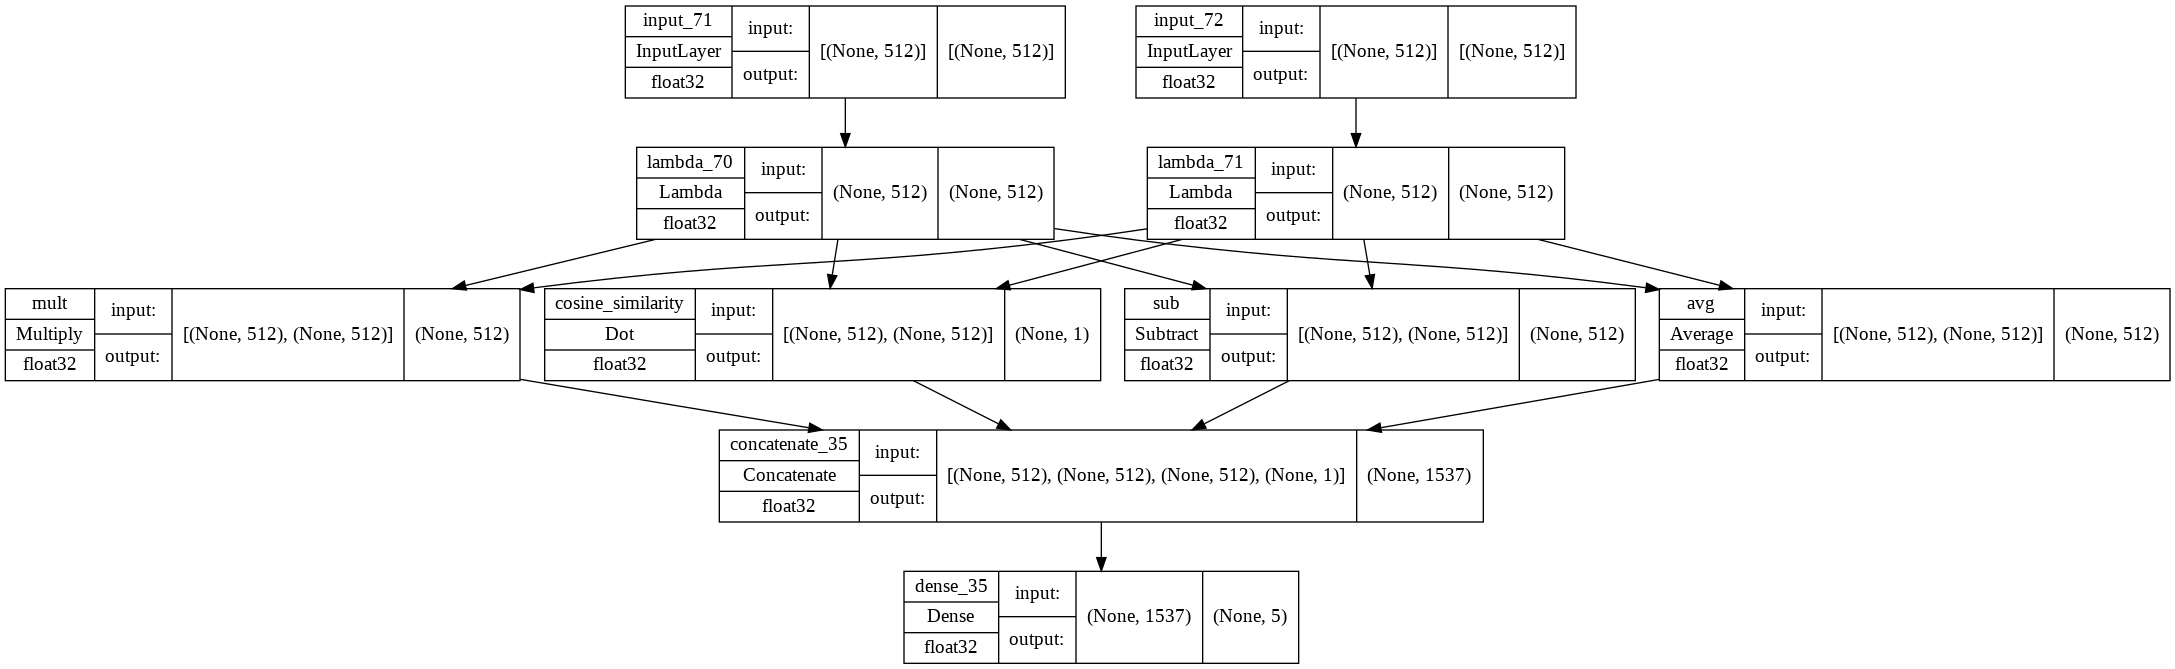

In [15]:
tf.keras.utils.plot_model(
    model,
    to_file="Embed_baseline.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)